In [4]:
# Get METAR data in bulk
%run auto_request_data.py

Enter airport ICAO code: RCSS
Enter end year: 2022
Enter end month: 3
Enter end day: 8
Enter end hour: 12
Enter time in months: 48
1 of 48 months retrieved
2 of 48 months retrieved
3 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
4 of 48 months retrieved
5 of 48 months retrieved
6 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
7 of 48 months retrieved
8 of 48 months retrieved
9 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
10 of 48 months retrieved
11 of 48 months retrieved
12 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
13 of 48 months retrieved
14 of 48 months retrieved
15 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
16 of 48 months retrieved
17 of 48 months retrieved
18 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
19 of 48 months retrieved
20 of 48 months retrieved
21 of 48 months retrieved
Pausing for 1 minute to prevent overloading...
22 

In [21]:
# Parse relevant METAR data into CSV
%run parse_to_csv.py RCSS

RCSS


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [3]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.2f}".format

In [22]:
airport = "RCSS"

train_df = pd.read_csv(airport + "/" + airport + "_train.csv")
test_df = pd.read_csv(airport + "/" + airport + "_test.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

print(train_df)

       month  windSpdKts  gustKts  windVrbDeg  intensity  rain  \
5613       8           6        0          70       0.00     0   
27897      1          13        0           0       0.00     0   
2906      11          10        0           0       0.30     1   
20251     12          17        0           0       0.00     0   
25125      4           8        0           0       0.30     1   
...      ...         ...      ...         ...        ...   ...   
28703     12           4        0           0       0.00     0   
4033      10          11        0           0       0.00     0   
5629       8           3        0          80       0.00     0   
10743      2           5        0           0       0.30     1   
23952      6           4        0           0       0.00     0   

       visibilityMtrs   qnh  ws  
5613             9999  1007   0  
27897            9999  1022   0  
2906             9999  1021   0  
20251            9999  1018   0  
25125            5000  1010   0  
...

In [23]:
train_df_norm = train_df.copy()
test_df_norm = test_df.copy()

# Scale down wind speed
train_df_norm["windSpdKts"] /= 50
test_df_norm["windSpdKts"] /= 50

# Scale down wind gust speed
train_df_norm["gustKts"] /= 50
test_df_norm["gustKts"] /= 50

# Scale down wind variability
train_df_norm["windVrbDeg"] /= 100
test_df_norm["windVrbDeg"] /= 100

# Scale down visibility
# train_df_norm["visibilityMtrs"] /= 10000
# test_df_norm["visibilityMtrs"] /= 10000

# Normalise, scale down QNH
train_df_norm["qnh"] -= 1013
train_df_norm["qnh"] /= 10
test_df_norm["qnh"] -= 1013
test_df_norm["qnh"] /= 10

print(train_df_norm)
print(test_df_norm)

       month  windSpdKts  gustKts  windVrbDeg  intensity  rain  \
5613       8        0.12     0.00        0.70       0.00     0   
27897      1        0.26     0.00        0.00       0.00     0   
2906      11        0.20     0.00        0.00       0.30     1   
20251     12        0.34     0.00        0.00       0.00     0   
25125      4        0.16     0.00        0.00       0.30     1   
...      ...         ...      ...         ...        ...   ...   
28703     12        0.08     0.00        0.00       0.00     0   
4033      10        0.22     0.00        0.00       0.00     0   
5629       8        0.06     0.00        0.80       0.00     0   
10743      2        0.10     0.00        0.00       0.30     1   
23952      6        0.08     0.00        0.00       0.00     0   

       visibilityMtrs   qnh  ws  
5613             9999 -0.60   0  
27897            9999  0.90   0  
2906             9999  0.80   0  
20251            9999  0.50   0  
25125            5000 -0.30   0  
...

In [24]:
feature_columns = []

month_boundaries = list(np.arange(1, 13))
month = tf.feature_column.numeric_column("month")
monthBin = tf.feature_column.bucketized_column(month, month_boundaries)
feature_columns.append(monthBin)
# print(monthBin)

windSpdKts = tf.feature_column.numeric_column("windSpdKts")
feature_columns.append(windSpdKts)

gustKts = tf.feature_column.numeric_column("gustKts")
feature_columns.append(gustKts)

windVrbDeg = tf.feature_column.numeric_column("windVrbDeg")
feature_columns.append(windVrbDeg)

intensity = tf.feature_column.numeric_column("intensity")
feature_columns.append(intensity)

rain = tf.feature_column.numeric_column("rain")
feature_columns.append(rain)

vis_boundaries = list(np.arange(-1, 10000, 1000))
visibilityMtrs = tf.feature_column.numeric_column("visibilityMtrs")
visibilityMtrsBin = tf.feature_column.bucketized_column(visibilityMtrs, vis_boundaries)
feature_columns.append(visibilityMtrsBin)
# print(visibilityMtrsBin)

qnh = tf.feature_column.numeric_column("qnh")
feature_columns.append(qnh)

# Create a feature cross of windSpdKts and windVrbDeg
spd_x_vrb = tf.feature_column.crossed_column(["windSpdKts", "windVrbDeg"], hash_bucket_size=1000)
crossed_spd_vrb = tf.feature_column.indicator_column(spd_x_vrb)
feature_columns.append(crossed_spd_vrb)

# Create a feature cross of intensity and rain
int_x_rain = tf.feature_column.crossed_column(["intensity", "rain"], hash_bucket_size=50)
crossed_int_rain = tf.feature_column.indicator_column(int_x_rain)
feature_columns.append(crossed_int_rain)

feature_layer = layers.DenseFeatures(feature_columns)

# np.set_printoptions(threshold=False)
# print(train_df_norm[train_df_norm.visibilityMtrs == train_df_norm.visibilityMtrs.min()])
# print(feature_layer(dict(train_df_norm)))

In [25]:
def neural_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a ReLU function.
    model.add(tf.keras.layers.Dense(units=40, activation='relu', name="hidden1",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(units=20, activation='relu', name="hidden2",
                                    kernel_regularizer=tf.keras.regularizers.l2(l=0.001)))
    
    # model.add(tf.keras.layers.Dropout(0.2))
    
    # Define the output layer.
    model.add(tf.keras.layers.Dense(units=1, name='Output', activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model


def linear_model(my_learning_rate, feature_layer, my_metrics, initial_bias=None):
    """Create and compile a simple classification model."""
    model = tf.keras.models.Sequential()
    
    if initial_bias is not None:
        initial_bias = tf.keras.initializers.Constant(initial_bias)
    
    model.add(feature_layer)

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(20,), activation='sigmoid', bias_initializer=initial_bias))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=my_learning_rate),                                                   
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=my_metrics)

    return model   


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True, validation_split=0.2):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays, where
    # each array contains the data for one feature.  Here, we're passing
    # every column in the dataset. Note that the feature_layer will filter
    # away most of those columns, leaving only the desired columns and their
    # representations as features.
    features = {name:np.array(value) for name, value in dataset.items()}
    label = np.array(features.pop(label_name)) 
    history = model.fit(x=features, y=label, batch_size=batch_size,
                          epochs=epochs, shuffle=shuffle, validation_split=validation_split)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist

print("Defined the 2 models and train_model functions.")

Defined the 2 models and train_model functions.


In [26]:
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""   

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()

print("Defined the plot_curve function.")

Defined the plot_curve function.


In [27]:
def get_initial_bias(train_set):
    pos_count = len(train_set[train_set.ws == 1])
    neg_count = train_set.size - pos_count
    return np.log([pos_count / neg_count])

Epoch 1/20
228/228 [==============================] - 2s 5ms/step - loss: 0.1945 - t-pos: 0.0000e+00 - f-pos: 0.0000e+00 - t-neg: 21912.0000 - f-neg: 812.0000 - accuracy: 0.9643 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.5473 - pr-auc: 0.0727 - val_loss: 0.1533 - val_t-pos: 0.0000e+00 - val_f-pos: 0.0000e+00 - val_t-neg: 9394.0000 - val_f-neg: 345.0000 - val_accuracy: 0.9646 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc-auc: 0.7591 - val_pr-auc: 0.1873
Epoch 2/20
228/228 [==============================] - 0s 2ms/step - loss: 0.1484 - t-pos: 0.0000e+00 - f-pos: 0.0000e+00 - t-neg: 21912.0000 - f-neg: 812.0000 - accuracy: 0.9643 - precision: 0.0000e+00 - recall: 0.0000e+00 - roc-auc: 0.7576 - pr-auc: 0.2108 - val_loss: 0.1417 - val_t-pos: 0.0000e+00 - val_f-pos: 0.0000e+00 - val_t-neg: 9394.0000 - val_f-neg: 345.0000 - val_accuracy: 0.9647 - val_precision: 1.0000 - val_recall: 0.0029 - val_roc-auc: 0.7745 - val_pr-auc: 0.2520
Epoch 3/20
228/228 [==========

228/228 [==============================] - 0s 2ms/step - loss: 0.1145 - t-pos: 165.0000 - f-pos: 44.0000 - t-neg: 21868.0000 - f-neg: 647.0000 - accuracy: 0.9699 - precision: 0.7602 - recall: 0.2303 - roc-auc: 0.9019 - pr-auc: 0.4727 - val_loss: 0.1165 - val_t-pos: 62.0000 - val_f-pos: 11.0000 - val_t-neg: 9383.0000 - val_f-neg: 283.0000 - val_accuracy: 0.9701 - val_precision: 0.8214 - val_recall: 0.2000 - val_roc-auc: 0.8865 - val_pr-auc: 0.4663
Epoch 14/20
228/228 [==============================] - 0s 2ms/step - loss: 0.1140 - t-pos: 169.0000 - f-pos: 38.0000 - t-neg: 21874.0000 - f-neg: 643.0000 - accuracy: 0.9703 - precision: 0.7810 - recall: 0.2328 - roc-auc: 0.9046 - pr-auc: 0.4811 - val_loss: 0.1195 - val_t-pos: 48.0000 - val_f-pos: 9.0000 - val_t-neg: 9385.0000 - val_f-neg: 297.0000 - val_accuracy: 0.9687 - val_precision: 0.8226 - val_recall: 0.1478 - val_roc-auc: 0.8782 - val_pr-auc: 0.4673
Epoch 15/20
228/228 [==============================] - 0s 2ms/step - loss: 0.1139 - t-p

[0.10940851271152496,
 73.0,
 13.0,
 13405.0,
 376.0,
 0.9725247025489807,
 0.8333333134651184,
 0.18930958211421967,
 0.8855872750282288,
 0.46133092045783997]

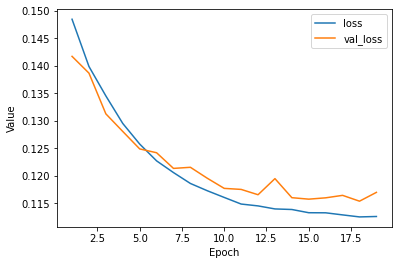

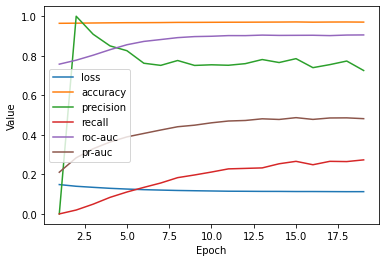

In [28]:
learning_rate = 0.0005
epochs = 20
batch_size = 100
label_name = "ws"
classification_threshold = 0.45
validation_split = 0.3
initial_bias = get_initial_bias(train_df_norm)

# Establish the metrics the model will measure.
METRICS = [
    tf.keras.metrics.TruePositives(name='t-pos'),
    tf.keras.metrics.FalsePositives(name='f-pos'),
    tf.keras.metrics.TrueNegatives(name='t-neg'),
    tf.keras.metrics.FalseNegatives(name='f-neg'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold,name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold,name='recall'),
    tf.keras.metrics.AUC(num_thresholds=100, name='roc-auc'),
    tf.keras.metrics.AUC(num_thresholds=100, name='pr-auc', curve='PR')
]

# Establish the model's topography.
my_model = neural_model(learning_rate, feature_layer, METRICS, initial_bias=initial_bias)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df_norm, epochs, 
                           label_name, batch_size, validation_split=validation_split)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot_1 = ['loss', 'val_loss']
list_of_metrics_to_plot_2 = ['loss', 'accuracy', 'precision', 'recall', 'roc-auc', 'pr-auc']

plot_curve(epochs, hist, list_of_metrics_to_plot_1)
plot_curve(epochs, hist, list_of_metrics_to_plot_2)

x_test = {name: np.array(value) for name, value in test_df_norm.items()}
y_test = np.array(x_test.pop(label_name))

my_model.evaluate(x_test, y_test, batch_size=batch_size)